# FIUFIP: Que No Se Escape Nadie

## Introducción

Este trabajo consiste en analizar una serie de datos recoletados por la agencia gubernamental de recaudación de impuestos *FIUFIP*.

Buscaremos entender como se relacionan estos datos y determinar un metodo de si una persona tiene **altos ingresos** o **bajos ingresos** a partir de los datos recibidos, que consisten en una serie de atributos de la persona que la agencia fue llenando y catalogando a la persona como de altos ingresos o no.



## Objetivos

**Tarea**: explicar qué conclusiones se pueden llegar a partir de analizar los datos recolectados

* Saber cómo entender cada uno de los datos
* Saber cómo se relacionan entre sí 
* Saber si se puede sacar alguna conclusión o descubrir un patrón a partir de estos

**Adicionalmente**

* Saber cuáles son los factores más importantes que determinan si un usuario **tiene altos** o **bajos ingresos** {*varible_target*}.

**Baseline**: código simple 

* intente predecir el target (si el usuario tiene **altos ingresos** o **bajos ingresos**).




## Carga de librerias y dataset

In [31]:
from collections import Counter 
import requests 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

Tambien leemos el dataset, que está en formato CSV desde Google Drive.

In [32]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("fiufip_dataset.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
        import pandas as pd


In [33]:
df = pd.read_csv("fiufip_dataset.csv")

# Ser contribuyente y proveer todos los datos a FIUFIP puede volverse complicado ¿Hay datos que falten en el dataset provisto?


Por ser una base de datos de la agencia FIUFIP, es posible que algunos contribuyentes hayan decido no responder o responder erroneamente a la hora de exponer sus datos personales. Esto puede llevar a que haya datos faltantes. Veamos si hay datos faltantes y ya que estamos visualicemos todas las features provistas en el dataset

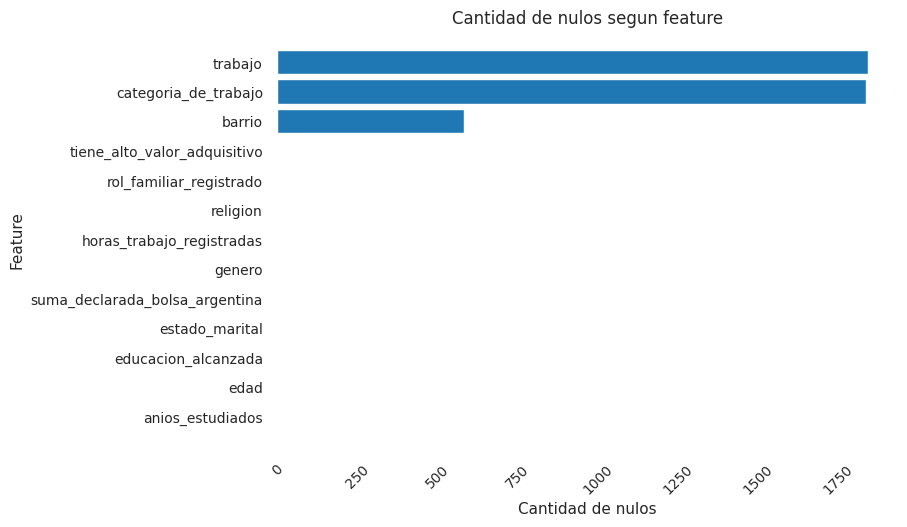

In [35]:
plt.figure(dpi = 100)
nulos = df.isnull().sum().sort_values(ascending = True)
nulos.rename(index={'ganancia_perdida_declarada_bolsa_argentina':'suma_declarada_bolsa_argentina'},inplace=True)

y_pos = np.arange(len(nulos.index))
plt.barh(y_pos, nulos.values, align='center')
plt.yticks(y_pos, nulos.index)
plt.ylabel('Feature')
plt.xlabel('Cantidad de nulos')
plt.xticks(rotation = 45)
plt.title('Cantidad de nulos segun feature')
plt.show()

Se pueden observar todas las features provistas. En particular solo tres de ellas presentan valores nulos. Resulta llamativo que los nulos en categoria de trabajo y trabajo sean similiares pero primero veamos sucede con la feature barrio 

## ¿Qué sucede y cómo se distribuye la feature barrio? ¿A qué puede deberse su cantidad de valores nulos?

Veamos la cantidad de posibles opciones de barrio que hay en el dataset

In [27]:
len(df.barrio.value_counts().index)


41

Lo primero a destacar es que hay 41 barrios mientrás que Capital Federal tiene 48, luego los datos faltantes podrían deberse a que no estaban todas las opciones disponibles al momento de obtener los datos. Debido a esto cambiemos el Nan por 'Otro' y veamos la distribución de la feature en cuestión

[]

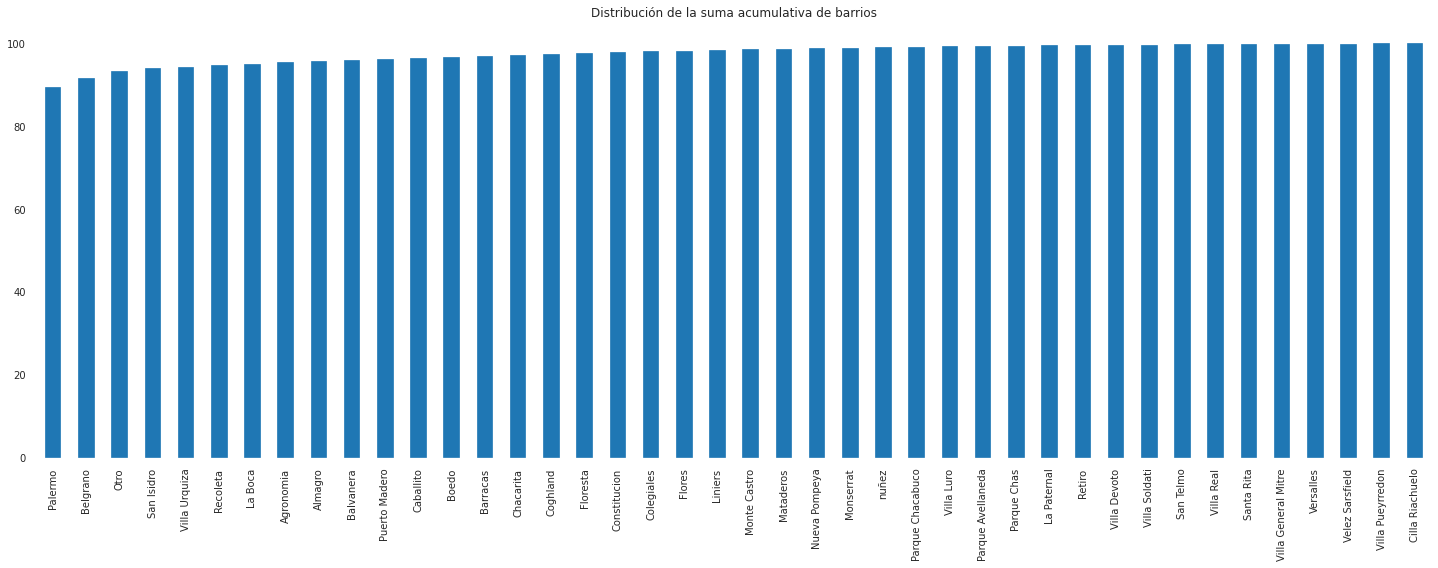

In [36]:
df['barrio'] = df['barrio'].replace(np.nan,'Otro')
barrios = df['barrio'].value_counts(normalize=True,dropna=False) * 100

barrios.cumsum().plot(
   kind='bar', title="Distribución de la suma acumulativa de barrios", figsize=(25, 8)
)
plt.plot()

De este gráfico, podemos observar que casi el 90% de los contribuyentes vive en el barrio de Palermo. Es decir, que se trata de una feature que además de tener una alta cardinaliad, tiene una baja varianza y a priori pareciera dificil poder establecer relaciones con otras variables

## ¿Qué sucede con los valores nulos en las features 'categoría de trabajo' y 'trabajo'? ¿Tiene alguna relación?

Como habiamos mencionado anteriormente, la cantidad de nulos en estas features es de un número parecido. Veamos si hay alguna relación que podamos observar

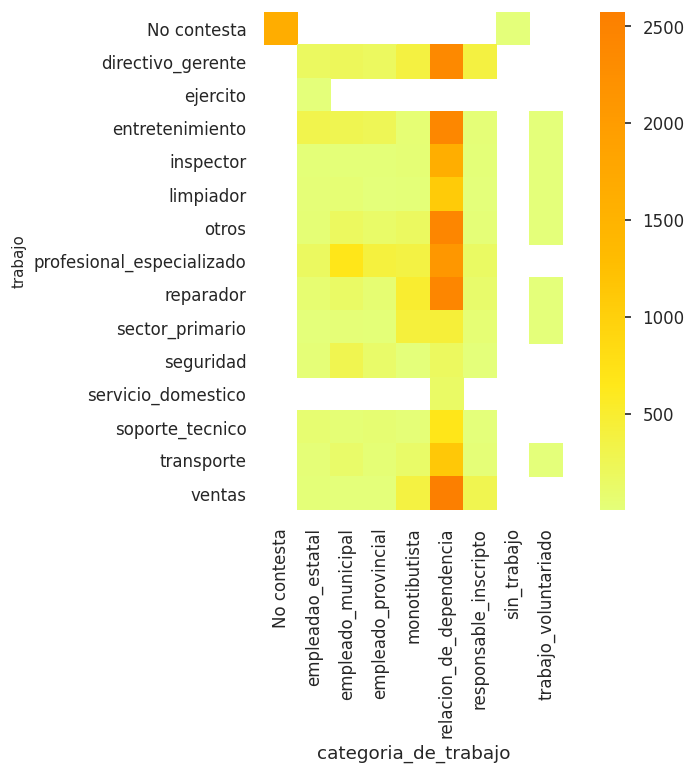

In [30]:
df['trabajo'] = df['trabajo'].replace(np.nan,'No contesta')
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].replace(np.nan,'No contesta')
tabla_pivot = pd.pivot_table(df,values='edad',index='trabajo',columns='categoria_de_trabajo',aggfunc='count').sort_index()
plt.figure(dpi=120)
plt.ylabel("Trabajo", fontsize=9)
sns.heatmap(tabla_pivot, square=True, cmap="Wistia")
plt.xticks(rotation = 90)
plt.show()


**Mi idea aca era hacer un heatmap, que muestre que la cantidad de gente que no contesto a categoria_trabajo es casi igual a la que no contesto trabajo, el proyecto no prospero. Tuve mas que nada problemas en la pivot table. Igual se visualiza lo que te digo si te fijas y se podrian poner algunas conclusiones adicionales**

** Hasta aca llegue, para mi habria que seguir verificando los valores numericos y que sean correctos, y luego si hay alguna feature en particular que valga la pena resaltar algo, como con los barrios (podemos revisar el profiling para ver si hay alguna idea). Otra cosa que falto es chequear valores falopa (esta en el otro notebook) y remplazarlo por nulos. Intente ir "contando" una historia para justificar cada cosa que me iba fijando. Lo mas complicado es claramente graficar, centremosnos en eso. Aca ya medio que veo la correlacion de dos variables, no lo veo mal porque conecta bien con fijarse por los nulos. **

4 minutos masomenos...

Relacion de dependencia, estatales, mono/responsable

In [ ]:
df.

# ¿Como son los niveles de educacion alcanzados?


### ¿Como se relaciona la cantidad de años estudiados segun el nivel de educacion alcanzada?

### ¿Hay equitatividad por genero en los niveles de educacion alcanzados?

# ¿Qué sucede con la educación de los encuestados?  

Texto

Conclusion

## ¿Hay alguna relacion la religion?

TExto

Conlcusion
